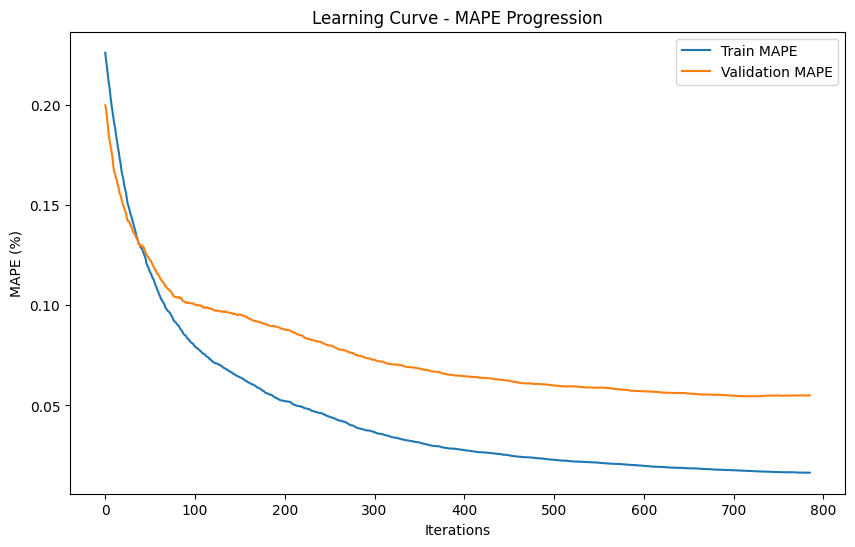


=== Final Validation Results ===
MAE: 0.07 ± 0.07
RMSE: 0.16 ± 0.16
MAPE: 34.29% ± 15.32
R²: 0.89 ± 0.10
Violations before clipping: 12 (7.55%)
Violations after clipping: 0 (0.00%)
Predictions within ±10%: 31.45%

=== Median MAE by Target Range ===
Target Range    MAE
0.0009-0.005 0.0022
  0.005-0.01 0.0016
   0.01-0.05 0.0081
    0.05-0.1 0.0090
     0.1-0.5 0.0318
       0.5-1 0.0992


C:\Users\adria\AppData\Local\Temp\ipykernel_2000\3771424410.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_mae = df_analysis.groupby('Target Range')['MAE'].median().reset_index()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# Apply square root transformations
for col in num_cols + [TARGET]:
    df[col] = np.sqrt(df[col])

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Best parameters with MAPE tracking
best_params = {
    'iterations': 786,
    'learning_rate': 0.0317,
    'depth': 5,
    'l2_leaf_reg': 2.216,
    'border_count': 83,
    'min_data_in_leaf': 34,
    'random_strength': 1.742,
    'subsample': 0.940,
    'bootstrap_type': 'Bernoulli',
    'feature_border_type': 'MaxLogSum',
    'grow_policy': 'SymmetricTree',
    'monotone_constraints': [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    'eval_metric': 'MAPE',
    'verbose': False
}

cost_components = [
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)',
    'Heat Treatment cost (€/Part)'
]

# Initialize storage for median MAE calculation
all_y_test_orig = []
all_y_pred_clipped = []

# 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_orig = np.square(y_pred)
    y_test_orig = np.square(y_test)
    
    # Store for median MAE calculation
    all_y_test_orig.extend(y_test_orig)
    all_y_pred_clipped.extend(y_pred_orig)  # Use clipped version from below
    
    # Calculate component costs sum
    sum_costs = np.sum(np.square(X_test[cost_components]), axis=1)
    
    # Track violations
    violations_before = np.sum(y_pred_orig < sum_costs)
    y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
    violations_after = np.sum(y_pred_clipped < sum_costs)
    
    # Update stored predictions with clipped values
    all_y_pred_clipped[-len(y_pred_clipped):] = y_pred_clipped
    
    # Store metrics
    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_clipped)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_clipped)/y_test_orig)) * 100)
    metrics['R2'].append(r2_score(y_test_orig, y_pred_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((y_pred_clipped - y_test_orig)/y_test_orig) <= 0.1))
    
    # Plot learning curve for last fold
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        plt.plot(eval_results['learn']['MAPE'], label='Train MAPE')
        plt.plot(eval_results['validation']['MAPE'], label='Validation MAPE')
        plt.title('Learning Curve - MAPE Progression')
        plt.xlabel('Iterations')
        plt.ylabel('MAPE (%)')
        plt.legend()
        plt.show()

# Convert to arrays for analysis
all_y_test_orig = np.array(all_y_test_orig)
all_y_pred_clipped = np.array(all_y_pred_clipped)

# Define target bins and labels
bins = [0.0009, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
labels = [
    '0.0009-0.005', '0.005-0.01', '0.01-0.05',
    '0.05-0.1', '0.1-0.5', '0.5-1' 
]

# Calculate MAE per sample and bin targets
mae_samples = np.abs(all_y_test_orig - all_y_pred_clipped)
bin_indices = pd.cut(all_y_test_orig, bins=bins, labels=labels, include_lowest=True)

# Create analysis dataframe
df_analysis = pd.DataFrame({
    'Actual': all_y_test_orig,
    'MAE': mae_samples,
    'Target Range': bin_indices
})

# Calculate median MAE per bin
median_mae = df_analysis.groupby('Target Range')['MAE'].median().reset_index()

# Print results
print("\n=== Final Validation Results ===")
print(f"MAE: {np.mean(metrics['MAE']):.2f} ± {np.std(metrics['MAE']):.2f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.2f} ± {np.std(metrics['RMSE']):.2f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.2f} ± {np.std(metrics['R2']):.2f}")
print(f"Violations before clipping: {sum(metrics['violations_before'])} ({sum(metrics['violations_before'])/len(X)*100:.2f}%)")
print(f"Violations after clipping: {sum(metrics['violations_after'])} ({sum(metrics['violations_after'])/len(X)*100:.2f}%)")
print(f"Predictions within ±10%: {sum(metrics['within_10%'])/len(X)*100:.2f}%")

# Print median MAE table
print("\n=== Median MAE by Target Range ===")
print(median_mae.to_string(index=False, formatters={
    'MAE': lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A"
}))



Tuning model: quantile_lgbm
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 127, number of used features: 11
[LightGBM] [Info] Start training from score 0.285257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Best params for huber: OrderedDict({'alpha': 0.9962156961987408, 'epsilon': 1.103725130388987})

Tuning model: gradient_boosting
Best params for gradient_boosting: OrderedDict({'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200})
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 127, number of used features: 11
[LightGBM] [Info] Start training from score 0.285257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 101, number of used features: 11
[LightGBM] [Info] Start training from score 0.285257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\adria\AppDa


Model Evaluation:

QUANTILE_LGBM Performance:


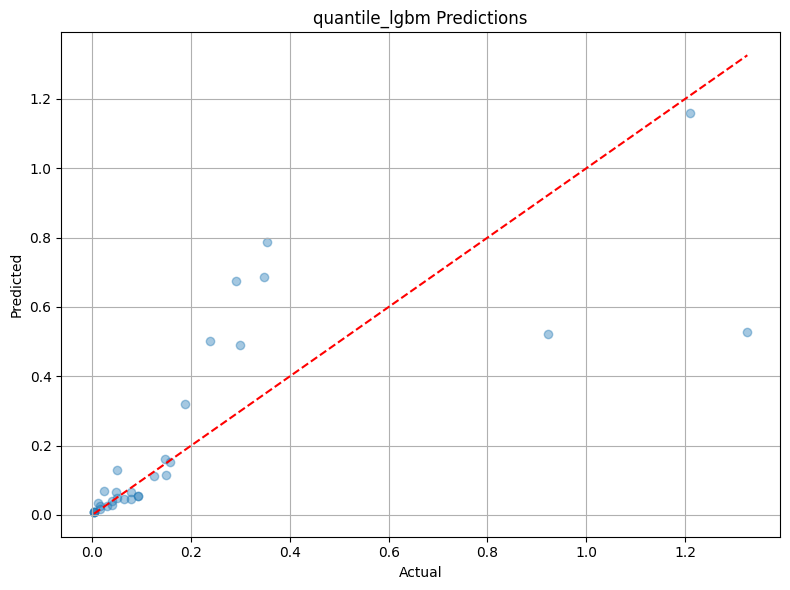

MAE: 0.0926
MSE: 0.0193
R²: 0.7532
Within_10%: 0.1875

HUBER Performance:


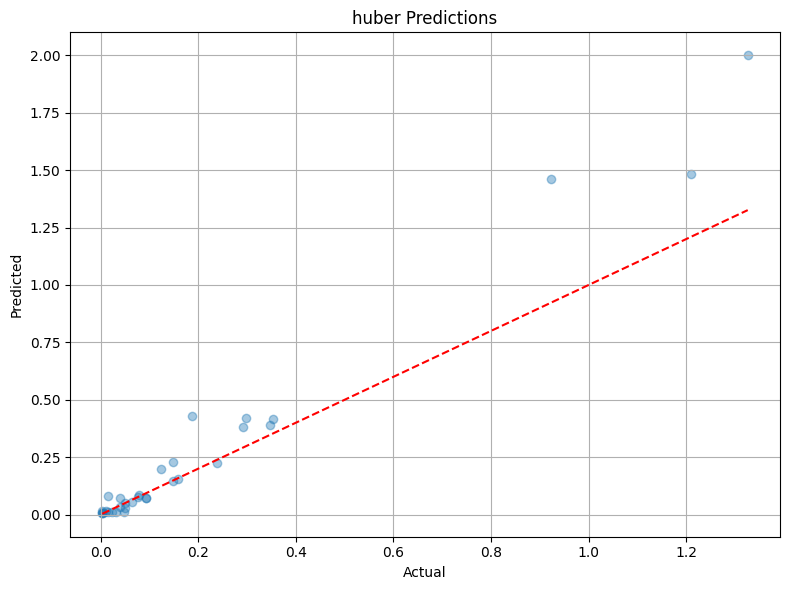

MAE: 0.0661
MSE: 0.0093
R²: 0.8807
Within_10%: 0.1562

GRADIENT_BOOSTING Performance:


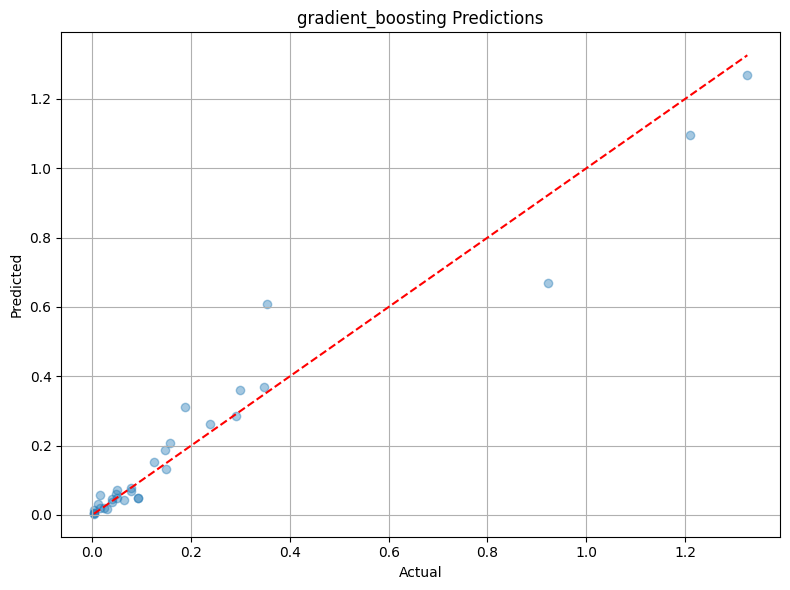

MAE: 0.0468
MSE: 0.0042
R²: 0.9465
Within_10%: 0.2812

STACKING ENSEMBLE Performance:


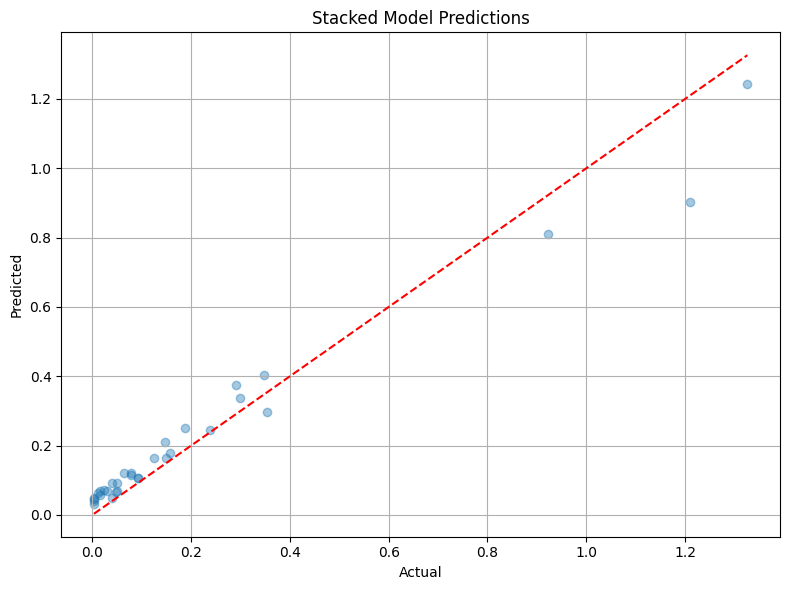

MAE: 0.0767
MSE: 0.0080
R²: 0.8973
Within_10%: 0.0625


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import lightgbm as lgb

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')

# Drop unused columns
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

# Define numeric and categorical columns
num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

# Fill missing values
df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# Target variable
TARGET = 'Total cost with amortization (€/part)'

# Apply square root transformation
for col in num_cols + [TARGET]:
    df[col] = np.sqrt(df[col])

X = df[num_cols + cat_cols]
y = df[TARGET]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define models with hyperparameter search space
models = {
    'quantile_lgbm': {
        'model': lgb.LGBMRegressor(objective='quantile', alpha=0.5),
        'params': {
            'n_estimators': Integer(50, 200),
            'num_leaves': Integer(10, 50),
            'learning_rate': Real(0.01, 0.2)
        }
    },
    'huber': {
        'model': HuberRegressor(),
        'params': {
            'epsilon': Real(1.1, 2.0),
            'alpha': Real(1e-4, 1.0)
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(loss='huber', random_state=42),
        'params': {
            'n_estimators': Integer(50, 200),
            'learning_rate': Real(0.01, 0.2),
            'max_depth': Integer(3, 7)
        }
    }
}

# Bayesian optimization for each model
best_models = {}
X_train_preprocessed = preprocessor.fit_transform(X_train)

for name, config in models.items():
    print(f"\nTuning model: {name}")
    bayes_cv = BayesSearchCV(
        estimator=config['model'],
        search_spaces=config['params'],
        n_iter=20,
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    bayes_cv.fit(X_train_preprocessed, y_train)
    best_models[name] = bayes_cv.best_estimator_
    print(f"Best params for {name}: {bayes_cv.best_params_}")

# Define stacking ensemble
estimators = [
    ('quantile_lgbm', best_models['quantile_lgbm']),
    ('huber', best_models['huber']),
    ('gbr', best_models['gradient_boosting'])
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=ElasticNet(alpha=0.1, l1_ratio=0.7),
    passthrough=True
)

# Train stacking model
stack.fit(X_train_preprocessed, y_train)

# Evaluation function
def evaluate_model(model, X, y, title='Model Evaluation'):
    X_preprocessed = preprocessor.transform(X)
    y_pred = model.predict(X_preprocessed)

    metrics = {
        'MAE': mean_absolute_error(y, y_pred),
        'MSE': mean_squared_error(y, y_pred),
        'R²': r2_score(y, y_pred),
        'Within_10%': np.mean(np.abs((y_pred**2 - y**2)/y**2) <= 0.10)
    }

    # Plot predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y**2, y_pred**2, alpha=0.4)
    plt.plot([y.min()**2, y.max()**2], [y.min()**2, y.max()**2], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics

# Evaluate all models
print("\nModel Evaluation:")
for name, model in best_models.items():
    print(f"\n{name.upper()} Performance:")
    metrics = evaluate_model(model, X_test, y_test, title=f'{name} Predictions')
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

print("\nSTACKING ENSEMBLE Performance:")
stack_metrics = evaluate_model(stack, X_test, y_test, title='Stacked Model Predictions')
for k, v in stack_metrics.items():
    print(f"{k}: {v:.4f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

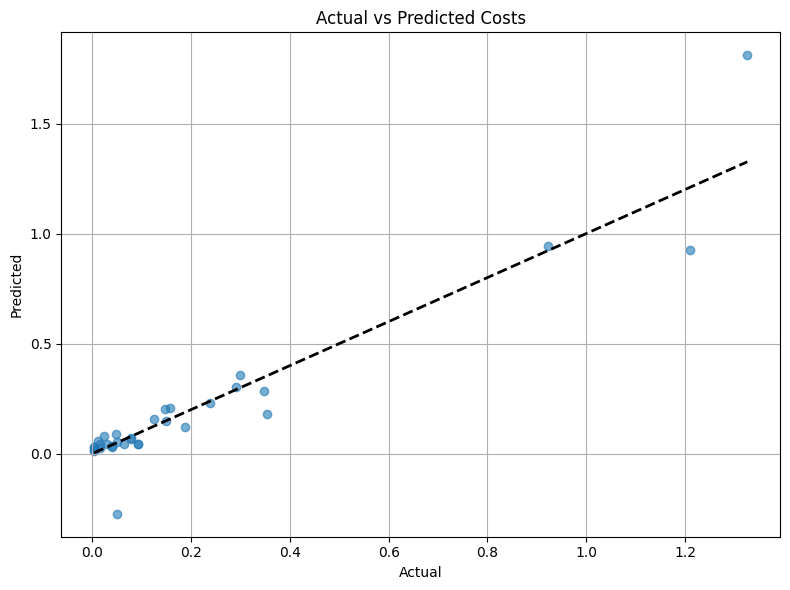

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from skopt import BayesSearchCV
from skopt.space import Real, Integer

import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

# ---------------------- Load and Preprocess Data ----------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')

# Drop unused columns
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
], errors='ignore')

# Define columns
num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

# Fill missing values
df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# Target
TARGET = 'Total cost with amortization (€/part)'
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found in data.")
y = df[TARGET]
X = df[num_cols + cat_cols]

# ---------------------- Preprocessing ----------------------
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# ---------------------- Model ----------------------
base_models = [
    ('elastic', ElasticNet()),
    ('huber', HuberRegressor()),
    ('gbr', GradientBoostingRegressor())
]

final_estimator = lgb.LGBMRegressor(random_state=42)

stack = StackingRegressor(
    estimators=base_models,
    final_estimator=final_estimator,
    passthrough=True,
    n_jobs=-1
)

# ---------------------- Pipeline ----------------------
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', stack)
])

# ---------------------- Hyperparameter Tuning ----------------------
search_space = {
    'model__final_estimator__n_estimators': Integer(100, 1000),
    'model__final_estimator__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'model__final_estimator__max_depth': Integer(3, 12),
    'model__final_estimator__num_leaves': Integer(20, 100),
    'model__final_estimator__min_child_samples': Integer(5, 50)
}

search = BayesSearchCV(
    pipeline,
    search_spaces=search_space,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# ---------------------- Train/Test Split and Fit ----------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
search.fit(X_train, y_train)

# ---------------------- Evaluation ----------------------
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Params:", search.best_params_)
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test R²: {r2:.3f}")

# ---------------------- Plot Results ----------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Costs")
plt.grid(True)
plt.tight_layout()
plt.show()


Mean RMSE: 0.2361
Mean MAE: 0.0944
Mean R²: 0.8435
Mean MAPE: 29.67%


NameError: name 'mape' is not defined

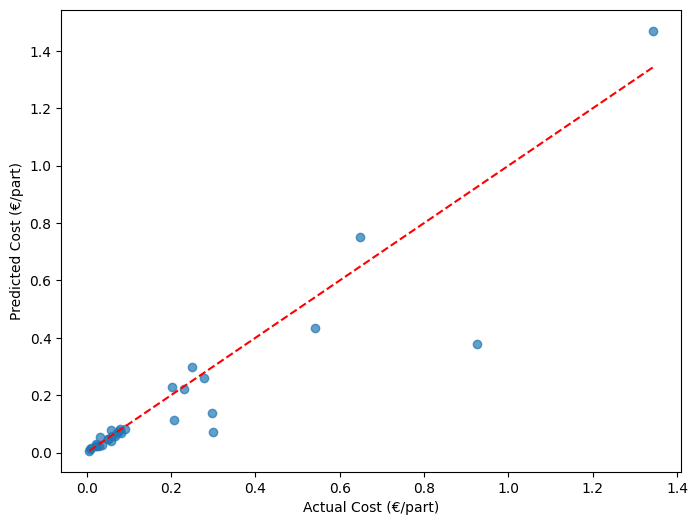

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')

# Encode categorical columns
categorical_cols = [
    'Production', 
    'Raw Material', 
    'Raw Material Designation', 
    'Surface Treatment'
]

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])

# Transform target variable
df['Total cost with amortization (€/part)'] = np.log10(
    df['Total cost with amortization (€/part)'] * 10000
)

# Define features and target
features = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)',
    'Surface Treatment cost (€/Part)', 'Production_encoded',
    'Raw Material_encoded', 'Raw Material Designation_encoded',
    'Surface Treatment_encoded'
]
target_col = 'Total cost with amortization (€/part)'
X = df[features]
y = df[target_col]

# Custom metrics functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

def inverse_transform(log_values):
    return (10 ** log_values) / 10000

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores, mae_scores, r2_scores, mape_scores = [], [], [], []

# Cross-validation
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = CatBoostRegressor(verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Back-transform metrics
    y_test_orig = inverse_transform(y_test)
    y_pred_orig = inverse_transform(y_pred)
    
    rmse_scores.append(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)))
    mae_scores.append(mean_absolute_error(y_test_orig, y_pred_orig))
    r2_scores.append(r2_score(y_test_orig, y_pred_orig))
    mape_scores.append(mean_absolute_percentage_error(y_test_orig, y_pred_orig))

# Print metrics
print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f}")
print(f"Mean R²: {np.mean(r2_scores):.4f}")
print(f"Mean MAPE: {np.mean(mape_scores):.2f}%")

# Final visualization
model_final = CatBoostRegressor(verbose=0)
model_final.fit(X_train, y_train)
y_pred_final = inverse_transform(model_final.predict(X_test))
y_test_final = inverse_transform(y_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_final, y_pred_final, alpha=0.7)
plt.plot([y_test_final.min(), y_test_final.max()], 
         [y_test_final.min(), y_test_final.max()], 'r--')
plt.xlabel('Actual Cost (€/part)')
plt.ylabel('Predicted Cost (€/part)')
plt.title(f'Actual vs Predicted\nMAPE: {mape:.2f}%')
plt.grid(True)
plt.show()


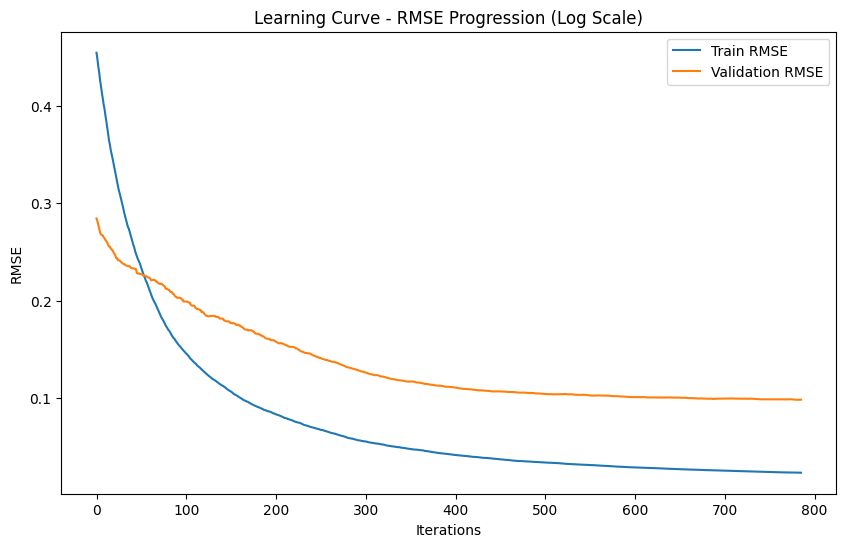


=== Final Validation Results (with Duan Smearing) ===
MAE: 0.0750 ± 0.0673
RMSE: 0.1600 ± 0.1655
MAPE: 60.14% ± 27.52
R²: 0.9105 ± 0.0667
Violations before clipping: 9 (5.66%)
Violations after clipping: 0 (0.00%)
Predictions within ±10%: 23.90%

=== Median MAE by Target Range ===
Target Range    MAE
0.0009-0.005 0.0107
  0.005-0.01 0.0087
   0.01-0.05 0.0181
    0.05-0.1 0.0104
     0.1-0.5 0.0297
       0.5-1 0.1006


C:\Users\adria\AppData\Local\Temp\ipykernel_24908\501017959.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_mae = df_analysis.groupby('Target Range')['MAE'].median().reset_index()


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# Apply log transformations with offset to handle values near zero
offset = 0.5
for col in num_cols + [TARGET]:
    df[col] = np.log(df[col] + offset)

X = df[num_cols + cat_cols]
y = df[TARGET]  # Already log-transformed
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Best parameters with MAPE tracking (adjusted for log scale)
best_params = {
    'iterations': 786,
    'learning_rate': 0.0317,
    'depth': 5,
    'l2_leaf_reg': 2.216,
    'border_count': 83,
    'min_data_in_leaf': 34,
    'random_strength': 1.742,
    'subsample': 0.940,
    'bootstrap_type': 'Bernoulli',
    'feature_border_type': 'MaxLogSum',
    'grow_policy': 'SymmetricTree',
    'monotone_constraints': [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    'eval_metric': 'RMSE',
    'verbose': False
}

cost_components = [
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)',
    'Heat Treatment cost (€/Part)'
]

# Initialize storage for metrics
all_y_test_orig = []
all_y_pred_clipped = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}

def calculate_duan_smearing_factor(residuals_log):
    return np.mean(np.exp(residuals_log))

def apply_duan_smearing(log_predictions, residuals_log, offset=0.5):
    smearing_factor = calculate_duan_smearing_factor(residuals_log)
    return np.exp(log_predictions) * smearing_factor - offset

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Get original scale values for validation
    y_test_orig = np.exp(y_test) - offset
    
    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    # Generate predictions and back-transform
    y_pred_log = model.predict(X_test)
    residuals_log = y_train - model.predict(X_train)
    y_pred_orig = apply_duan_smearing(y_pred_log, residuals_log, offset)
    
    # Store for analysis
    all_y_test_orig.extend(y_test_orig)
    all_y_pred_clipped.extend(y_pred_orig)
    
    # CORRECTED: Sum cost components with proper axis
    sum_costs = np.sum([
        np.exp(X_test[col]) - offset 
        for col in cost_components
    ], axis=0)  # Changed to axis=0 for proper summation
    
    # Track violations (now compatible shapes)
    violations_before = np.sum(y_pred_orig < sum_costs)
    y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
    violations_after = np.sum(y_pred_clipped < sum_costs)
    
    # Update stored predictions
    all_y_pred_clipped[-len(y_pred_clipped):] = y_pred_clipped
    
    # Calculate metrics
    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_clipped)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_clipped)/y_test_orig)) * 100)
    metrics['R2'].append(r2_score(y_test_orig, y_pred_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((y_pred_clipped - y_test_orig)/y_test_orig) <= 0.1))

    # Plot learning curve for last fold
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        plt.plot(eval_results['learn']['RMSE'], label='Train RMSE')
        plt.plot(eval_results['validation']['RMSE'], label='Validation RMSE')
        plt.title('Learning Curve - RMSE Progression (Log Scale)')
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.legend()
        plt.show()

# Convert to arrays for analysis
all_y_test_orig = np.array(all_y_test_orig)
all_y_pred_clipped = np.array(all_y_pred_clipped)

# Define target bins and labels
bins = [0.0009, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
labels = [
    '0.0009-0.005', '0.005-0.01', '0.01-0.05',
    '0.05-0.1', '0.1-0.5', '0.5-1' 
]

# Calculate MAE per sample and bin targets
mae_samples = np.abs(all_y_test_orig - all_y_pred_clipped)
bin_indices = pd.cut(all_y_test_orig, bins=bins, labels=labels, include_lowest=True)

# Create analysis dataframe
df_analysis = pd.DataFrame({
    'Actual': all_y_test_orig,
    'MAE': mae_samples,
    'Target Range': bin_indices
})

# Calculate median MAE per bin
median_mae = df_analysis.groupby('Target Range')['MAE'].median().reset_index()

# Print results
print("\n=== Final Validation Results (with Duan Smearing) ===")
print(f"MAE: {np.mean(metrics['MAE']):.4f} ± {np.std(metrics['MAE']):.4f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.4f} ± {np.std(metrics['RMSE']):.4f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.4f} ± {np.std(metrics['R2']):.4f}")
print(f"Violations before clipping: {sum(metrics['violations_before'])} ({sum(metrics['violations_before'])/len(X)*100:.2f}%)")
print(f"Violations after clipping: {sum(metrics['violations_after'])} ({sum(metrics['violations_after'])/len(X)*100:.2f}%)")
print(f"Predictions within ±10%: {sum(metrics['within_10%'])/len(X)*100:.2f}%")

# Print median MAE table
print("\n=== Median MAE by Target Range ===")
print(median_mae.to_string(index=False, formatters={
    'MAE': lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A"
}))


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


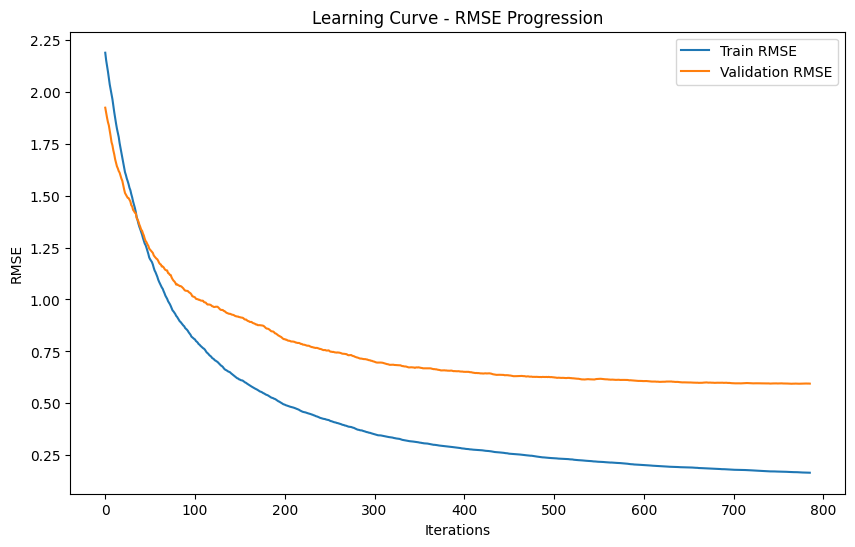


=== Final Validation Results ===
MAE: 0.0768 ± 0.0623
RMSE: 0.1801 ± 0.1638
MAPE: 29.52% ± 11.31
R²: 0.8618 ± 0.1332
Violations before clipping: 11 (6.92%)
Violations after clipping: 0 (0.00%)
Predictions within ±10%: 32.08%

=== Median MAE by Target Range ===
Target Range    MAE
0.0009-0.005 0.0037
  0.005-0.01 0.0018
   0.01-0.05 0.0060
    0.05-0.1 0.0088
     0.1-0.5 0.0295
       0.5-1 0.0853


C:\Users\adria\AppData\Local\Temp\ipykernel_24908\159643838.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_mae = df_analysis.groupby('Target Range')['MAE'].median().reset_index()


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# Apply negative log base 0.5 transformation
for col in num_cols + [TARGET]:
    df[col] = -np.log(df[col]) / np.log(0.5)  # Equivalent to log2(y)

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Updated parameters for log2 scale
best_params = {
    'iterations': 786,
    'learning_rate': 0.0317,
    'depth': 5,
    'l2_leaf_reg': 2.216,
    'border_count': 83,
    'min_data_in_leaf': 34,
    'random_strength': 1.742,
    'subsample': 0.940,
    'bootstrap_type': 'Bernoulli',
    'feature_border_type': 'MaxLogSum',
    'grow_policy': 'SymmetricTree',
    'monotone_constraints': [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    'eval_metric': 'RMSE',
    'verbose': False
}

cost_components = [
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)',
    'Heat Treatment cost (€/Part)'
]

# Initialize storage for metrics
all_y_test_orig = []
all_y_pred_clipped = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}

def calculate_duan_smearing_factor(residuals):
    """Calculate smearing factor for log2 transformation"""
    return np.mean(2 ** residuals)

def apply_duan_smearing(log_predictions, residuals):
    """Apply Duan smearing for log2 scale"""
    smearing_factor = calculate_duan_smearing_factor(residuals)
    return (2 ** log_predictions) * smearing_factor

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Get original scale values
    y_test_orig = 2 ** y_test
    
    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    # Generate predictions and residuals
    y_pred_log = model.predict(X_test)
    residuals = y_train - model.predict(X_train)
    
    # Apply Duan smearing
    y_pred_orig = apply_duan_smearing(y_pred_log, residuals)
    
    # Store results
    all_y_test_orig.extend(y_test_orig)
    all_y_pred_clipped.extend(y_pred_orig)
    
    # Calculate component costs (original scale)
    sum_costs = np.sum([2 ** X_test[col] for col in cost_components], axis=0)
    
    # Track violations
    violations_before = np.sum(y_pred_orig < sum_costs)
    y_pred_clipped = np.maximum(y_pred_orig, sum_costs)
    violations_after = np.sum(y_pred_clipped < sum_costs)
    
    # Update stored predictions
    all_y_pred_clipped[-len(y_pred_clipped):] = y_pred_clipped
    
    # Calculate metrics
    metrics['MAE'].append(mean_absolute_error(y_test_orig, y_pred_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_clipped)))
    metrics['MAPE'].append(np.mean(np.abs((y_test_orig - y_pred_clipped)/y_test_orig)) * 100)
    metrics['R2'].append(r2_score(y_test_orig, y_pred_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((y_pred_clipped - y_test_orig)/y_test_orig) <= 0.1))

    # Plot learning curve for last fold
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        plt.plot(eval_results['learn']['RMSE'], label='Train RMSE')
        plt.plot(eval_results['validation']['RMSE'], label='Validation RMSE')
        plt.title('Learning Curve - RMSE Progression')
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.legend()
        plt.show()

# Convert to arrays for analysis
all_y_test_orig = np.array(all_y_test_orig)
all_y_pred_clipped = np.array(all_y_pred_clipped)

# Define target bins and labels
bins = [0.0009, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
labels = [
    '0.0009-0.005', '0.005-0.01', '0.01-0.05',
    '0.05-0.1', '0.1-0.5', '0.5-1' 
]

# Calculate MAE per sample and bin targets
mae_samples = np.abs(all_y_test_orig - all_y_pred_clipped)
bin_indices = pd.cut(all_y_test_orig, bins=bins, labels=labels, include_lowest=True)

# Create analysis dataframe
df_analysis = pd.DataFrame({
    'Actual': all_y_test_orig,
    'MAE': mae_samples,
    'Target Range': bin_indices
})

# Calculate median MAE per bin
median_mae = df_analysis.groupby('Target Range')['MAE'].median().reset_index()

# Print results
print("\n=== Final Validation Results ===")
print(f"MAE: {np.mean(metrics['MAE']):.4f} ± {np.std(metrics['MAE']):.4f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.4f} ± {np.std(metrics['RMSE']):.4f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.4f} ± {np.std(metrics['R2']):.4f}")
print(f"Violations before clipping: {sum(metrics['violations_before'])} ({sum(metrics['violations_before'])/len(X)*100:.2f}%)")
print(f"Violations after clipping: {sum(metrics['violations_after'])} ({sum(metrics['violations_after'])/len(X)*100:.2f}%)")
print(f"Predictions within ±10%: {sum(metrics['within_10%'])/len(X)*100:.2f}%")

# Print median MAE table
print("\n=== Median MAE by Target Range ===")
print(median_mae.to_string(index=False, formatters={
    'MAE': lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A"
}))


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


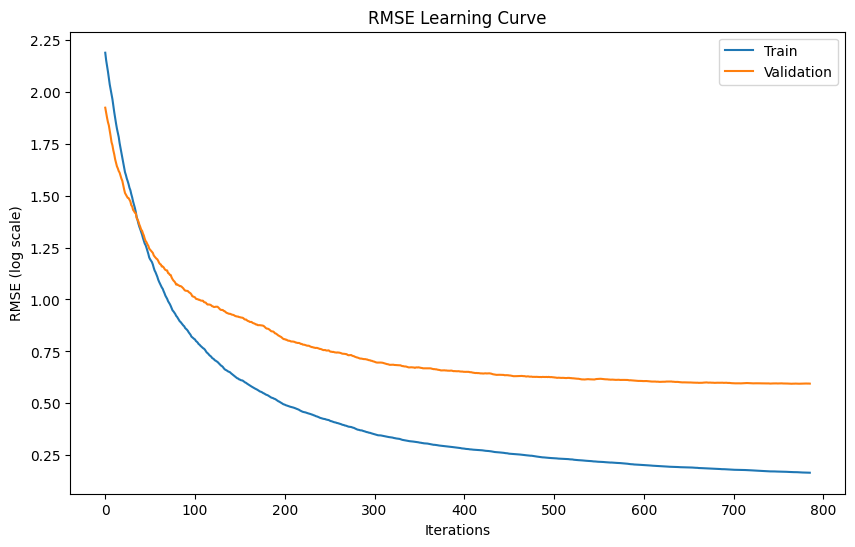


=== Final Metrics ===
MAE: 0.0768 ± 0.0623
RMSE: 0.1801 ± 0.1638
MAPE: 29.52% ± 11.31
R²: 0.8618 ± 0.1332
Violations reduced from 11 to 0
Within ±10%: 32.1%

=== Error by Cost Range ===
Range
(0.0009, 0.005]    0.0037
(0.005, 0.01]      0.0018
(0.01, 0.05]       0.0060
(0.05, 0.1]        0.0088
(0.1, 0.5]         0.0295
(0.5, 1.0]         0.0853
Name: Error, dtype: float64


C:\Users\adria\AppData\Local\Temp\ipykernel_24908\2144121581.py:145: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_analysis.groupby('Range')['Error'].median().round(4))


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# Apply log₂ transformation (equivalent to -log_0.5)
for col in num_cols + [TARGET]:
    df[col] = np.log2(df[col])  # Direct log base 2 transformation

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Model parameters
best_params = {
    'iterations': 786,
    'learning_rate': 0.0317,
    'depth': 5,
    'l2_leaf_reg': 2.216,
    'border_count': 83,
    'min_data_in_leaf': 34,
    'random_strength': 1.742,
    'subsample': 0.940,
    'bootstrap_type': 'Bernoulli',
    'feature_border_type': 'MaxLogSum',
    'grow_policy': 'SymmetricTree',
    'monotone_constraints': [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    'eval_metric': 'RMSE',
    'verbose': False
}

cost_components = [
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)',
    'Heat Treatment cost (€/Part)'
]

# Initialize metrics storage
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}
all_y_test_orig = []
all_y_pred_clipped = []

# Duan smearing functions
def calculate_smearing_factor(residuals):
    return np.mean(2 ** residuals)

def apply_smearing(predictions, residuals):
    return (2 ** predictions) * calculate_smearing_factor(residuals)

# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    # Generate predictions
    log_preds = model.predict(X_test)
    residuals = y_train - model.predict(X_train)
    
    # Apply Duan smearing
    preds_orig = apply_smearing(log_preds, residuals)
    y_test_orig = 2 ** y_test
    
    # Cost components sum
    sum_costs = np.sum([2 ** X_test[col] for col in cost_components], axis=0)
    
    # Clipping logic
    violations_before = np.sum(preds_orig < sum_costs)
    preds_clipped = np.maximum(preds_orig, sum_costs)
    violations_after = np.sum(preds_clipped < sum_costs)
    
    # Store results
    all_y_test_orig.extend(y_test_orig)
    all_y_pred_clipped.extend(preds_clipped)
    
    # Calculate metrics
    metrics['MAE'].append(mean_absolute_error(y_test_orig, preds_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, preds_clipped)))
    metrics['MAPE'].append(100 * np.mean(np.abs((y_test_orig - preds_clipped)/y_test_orig)))
    metrics['R2'].append(r2_score(y_test_orig, preds_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((preds_clipped - y_test_orig)/y_test_orig) <= 0.1))

    # Final fold visualizations
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        plt.plot(eval_results['learn']['RMSE'], label='Train')
        plt.plot(eval_results['validation']['RMSE'], label='Validation')
        plt.title('RMSE Learning Curve')
        plt.xlabel('Iterations')
        plt.ylabel('RMSE (log scale)')
        plt.legend()
        plt.show()

# Results analysis
print("\n=== Final Metrics ===")
print(f"MAE: {np.mean(metrics['MAE']):.4f} ± {np.std(metrics['MAE']):.4f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.4f} ± {np.std(metrics['RMSE']):.4f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.4f} ± {np.std(metrics['R2']):.4f}")
print(f"Violations reduced from {sum(metrics['violations_before'])} to {sum(metrics['violations_after'])}")
print(f"Within ±10%: {sum(metrics['within_10%'])/len(X)*100:.1f}%")

# Bin analysis
bins = [0.0009, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
df_analysis = pd.DataFrame({
    'Actual': all_y_test_orig,
    'Error': np.abs(np.array(all_y_test_orig) - np.array(all_y_pred_clipped))
})
df_analysis['Range'] = pd.cut(df_analysis['Actual'], bins=bins)

print("\n=== Error by Cost Range ===")
print(df_analysis.groupby('Range')['Error'].median().round(4))


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


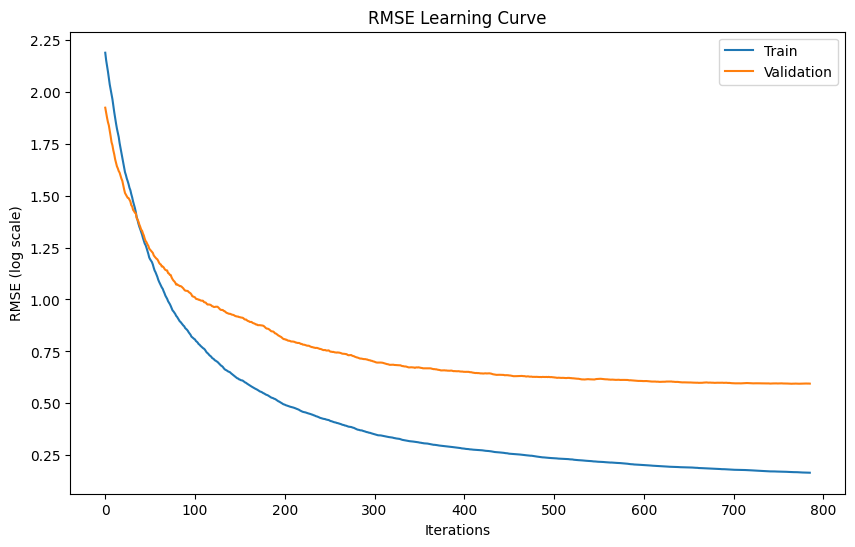


=== Final Metrics ===
MAE: 0.0768 ± 0.0623
RMSE: 0.1801 ± 0.1638
MAPE: 29.52% ± 11.31
R²: 0.8618 ± 0.1332
Violations reduced from 11 to 0
Within ±10%: 32.1%

=== Error by Cost Range ===
Range
(0.0009, 0.005]    0.0037
(0.005, 0.01]      0.0018
(0.01, 0.05]       0.0060
(0.05, 0.1]        0.0088
(0.1, 0.5]         0.0295
(0.5, 1.0]         0.0853
Name: Error, dtype: float64


C:\Users\adria\AppData\Local\Temp\ipykernel_24908\2144121581.py:145: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_analysis.groupby('Range')['Error'].median().round(4))


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
TARGET = 'Total cost with amortization (€/part)'

# Apply log₂ transformation (equivalent to -log_0.5)
for col in num_cols + [TARGET]:
    df[col] = np.log2(df[col])  # Direct log base 2 transformation

X = df[num_cols + cat_cols]
y = df[TARGET]
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Model parameters
best_params = {
    'iterations': 786,
    'learning_rate': 0.0317,
    'depth': 5,
    'l2_leaf_reg': 2.216,
    'border_count': 83,
    'min_data_in_leaf': 34,
    'random_strength': 1.742,
    'subsample': 0.940,
    'bootstrap_type': 'Bernoulli',
    'feature_border_type': 'MaxLogSum',
    'grow_policy': 'SymmetricTree',
    'monotone_constraints': [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    'eval_metric': 'RMSE',
    'verbose': False
}

cost_components = [
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)',
    'Heat Treatment cost (€/Part)'
]

# Initialize metrics storage
kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics = {
    'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': [],
    'violations_before': [], 'violations_after': [],
    'within_10%': []
}
all_y_test_orig = []
all_y_pred_clipped = []

# Duan smearing functions
def calculate_smearing_factor(residuals):
    return np.mean(2 ** residuals)

def apply_smearing(predictions, residuals):
    return (2 ** predictions) * calculate_smearing_factor(residuals)

# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    # Generate predictions
    log_preds = model.predict(X_test)
    residuals = y_train - model.predict(X_train)
    
    # Apply Duan smearing
    preds_orig = apply_smearing(log_preds, residuals)
    y_test_orig = 2 ** y_test
    
    # Cost components sum
    sum_costs = np.sum([2 ** X_test[col] for col in cost_components], axis=0)
    
    # Clipping logic
    violations_before = np.sum(preds_orig < sum_costs)
    preds_clipped = np.maximum(preds_orig, sum_costs)
    violations_after = np.sum(preds_clipped < sum_costs)
    
    # Store results
    all_y_test_orig.extend(y_test_orig)
    all_y_pred_clipped.extend(preds_clipped)
    
    # Calculate metrics
    metrics['MAE'].append(mean_absolute_error(y_test_orig, preds_clipped))
    metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, preds_clipped)))
    metrics['MAPE'].append(100 * np.mean(np.abs((y_test_orig - preds_clipped)/y_test_orig)))
    metrics['R2'].append(r2_score(y_test_orig, preds_clipped))
    metrics['violations_before'].append(violations_before)
    metrics['violations_after'].append(violations_after)
    metrics['within_10%'].append(np.sum(np.abs((preds_clipped - y_test_orig)/y_test_orig) <= 0.1))

    # Final fold visualizations
    if fold == 9:
        plt.figure(figsize=(10, 6))
        eval_results = model.get_evals_result()
        plt.plot(eval_results['learn']['RMSE'], label='Train')
        plt.plot(eval_results['validation']['RMSE'], label='Validation')
        plt.title('RMSE Learning Curve')
        plt.xlabel('Iterations')
        plt.ylabel('RMSE (log scale)')
        plt.legend()
        plt.show()

# Results analysis
print("\n=== Final Metrics ===")
print(f"MAE: {np.mean(metrics['MAE']):.4f} ± {np.std(metrics['MAE']):.4f}")
print(f"RMSE: {np.mean(metrics['RMSE']):.4f} ± {np.std(metrics['RMSE']):.4f}")
print(f"MAPE: {np.mean(metrics['MAPE']):.2f}% ± {np.std(metrics['MAPE']):.2f}")
print(f"R²: {np.mean(metrics['R2']):.4f} ± {np.std(metrics['R2']):.4f}")
print(f"Violations reduced from {sum(metrics['violations_before'])} to {sum(metrics['violations_after'])}")
print(f"Within ±10%: {sum(metrics['within_10%'])/len(X)*100:.1f}%")

# Bin analysis
bins = [0.0009, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
df_analysis = pd.DataFrame({
    'Actual': all_y_test_orig,
    'Error': np.abs(np.array(all_y_test_orig) - np.array(all_y_pred_clipped))
})
df_analysis['Range'] = pd.cut(df_analysis['Actual'], bins=bins)

print("\n=== Error by Cost Range ===")
print(df_analysis.groupby('Range')['Error'].median().round(4))


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

# Filter rows where target > 0.4
TARGET = 'Total cost with amortization (€/part)'
df = df[df[TARGET] <= 0.4]

# Apply log2 transformation to numerical features (original preprocessing)
for col in num_cols:
    df[col] = np.log2(df[col])

df[cat_cols] = df[cat_cols].fillna('Missing')
X = df[num_cols + cat_cols]
y_orig = df[TARGET]  # Original untransformed target
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

# Model parameters
best_params = {
    'iterations': 786,
    'learning_rate': 0.0317,
    'depth': 5,
    'l2_leaf_reg': 2.216,
    'border_count': 83,
    'min_data_in_leaf': 34,
    'random_strength': 1.742,
    'subsample': 0.940,
    'bootstrap_type': 'Bernoulli',
    'feature_border_type': 'MaxLogSum',
    'grow_policy': 'SymmetricTree',
    'monotone_constraints': [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    'eval_metric': 'RMSE',
    'verbose': False
}

cost_components = [
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)',
    'Heat Treatment cost (€/Part)'
]

# Initialize metrics storage for strategies
strategies = ['Log Transform', 'Box-Cox', 'Log with Duan Smearing']
metrics = {s: {'MAE': [], 'RMSE': [], 'MAPE': [], 'R2': []} for s in strategies}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_orig, y_test_orig = y_orig.iloc[train_idx], y_orig.iloc[test_idx]
    
    # Strategy 1: Simple Log Transform
    y_train_log = np.log(y_train_orig + 1e-8)
    model_log = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model_log.fit(X_train, y_train_log)
    preds_log = np.exp(model_log.predict(X_test)) - 1e-8
    
    # Strategy 2: Box-Cox Transform
    y_train_bc, lambda_ = boxcox(y_train_orig + 1e-8)
    model_bc = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model_bc.fit(X_train, y_train_bc)
    preds_bc = inv_boxcox(model_bc.predict(X_test), lambda_) - 1e-8
    
    # Strategy 3: Log with Duan Smearing
    model_duan = CatBoostRegressor(**best_params, cat_features=cat_indices)
    model_duan.fit(X_train, y_train_log)
    residuals = y_train_log - model_duan.predict(X_train)
    smearing_factor = np.mean(np.exp(residuals))
    preds_duan = np.exp(model_duan.predict(X_test)) * smearing_factor - 1e-8
    
    # Common post-processing for all strategies
    sum_costs = np.sum([2**X_test[col] for col in cost_components], axis=0)
    
    for strategy, preds in zip(strategies, [preds_log, preds_bc, preds_duan]):
        preds_clipped = np.maximum(preds, sum_costs)
        
        metrics[strategy]['MAE'].append(mean_absolute_error(y_test_orig, preds_clipped))
        metrics[strategy]['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, preds_clipped)))
        metrics[strategy]['MAPE'].append(100 * np.mean(np.abs((y_test_orig - preds_clipped)/y_test_orig)))
        metrics[strategy]['R2'].append(r2_score(y_test_orig, preds_clipped))

# Compile results
results = []
for strategy in strategies:
    results.append({
        'Strategy': strategy,
        'MAE': f'{np.mean(metrics[strategy]["MAE"]):.4f} ± {np.std(metrics[strategy]["MAE"]):.4f}',
        'RMSE': f'{np.mean(metrics[strategy]["RMSE"]):.4f} ± {np.std(metrics[strategy]["RMSE"]):.4f}',
        'MAPE (%)': f'{np.mean(metrics[strategy]["MAPE"]):.2f} ± {np.std(metrics[strategy]["MAPE"]):.2f}',
        'R²': f'{np.mean(metrics[strategy]["R2"]):.4f} ± {np.std(metrics[strategy]["R2"]):.4f}'
    })

# Display comparison table
print("\n=== Transformation Strategy Comparison ===")
print(pd.DataFrame(results).to_string(index=False))


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Transformation Strategy Comparison ===
              Strategy             MAE            RMSE      MAPE (%)              R²
         Log Transform 0.0238 ± 0.0084 0.0381 ± 0.0163 34.28 ± 14.82 0.7565 ± 0.1853
               Box-Cox 0.0233 ± 0.0080 0.0365 ± 0.0140 39.82 ± 21.69 0.7842 ± 0.1314
Log with Duan Smearing 0.0239 ± 0.0085 0.0379 ± 0.0167 33.68 ± 13.64 0.7568 ± 0.1902
